# Mock exam additional exercises

In [1]:
# Import modules
from itertools import combinations
import pandas as pd
import numpy as np

# Set pandas number format
pd.options.display.float_format = '{:,.2f}'.format

## Exercise 1

### Data pre-processing

#### Import population data

In [2]:
# Set file path
FILEPATH = "../data/exiobase/EXIOBASE_PopulationGDP_1995_2019.xlsx"

# Load Eurostat data
population_per_region = pd.read_excel(
    FILEPATH, 
    engine = "openpyxl", 
    sheet_name = 'Population',  # None = all sheets
    header = 0,  # [,] -> multiindex for columns
    index_col = 2,  # [,]  -> multiindex for index
    skipfooter = 0,
)

# Clean population data
YEAR = 'y2017'
population_per_region = population_per_region[YEAR]
# population_per_region

#### Import Exiobase data

Please donwload and use exiobase’s 2017 MRIO data (industry by industry) Make sure you locate to
exiobase’ latest version on Zenodo.

In [3]:
dir_path = "../data/exiobase/_ixi/IOT_2017_ixi/"

In [4]:
# Import A, Y, F and F_Y (from SATELLITE)
# ! 'A' is a large datasets, mind load time
A = pd.read_csv(f'{dir_path}A.txt', delimiter="\t", header=[0,1], index_col=[0,1])
Y = pd.read_csv(f'{dir_path}Y.txt', delimiter="\t", header=[0,1], index_col=[0,1])
# ! we use the satellite folder this time because we will look at uncharacterized stressors (CO2 emission vs GWP100)
F = pd.read_csv(f'{dir_path}satellite/F.txt', delimiter="\t", header=[0,1], index_col=[0])
F_y = pd.read_csv(f'{dir_path}satellite/F_Y.txt', delimiter="\t", header=[0,1], index_col=[0])
F_unit = pd.read_csv(f'{dir_path}satellite/unit.txt', delimiter="\t", header=0, index_col=[0])

#### Get labels

In [5]:
# get multiindex
region_and_sector_labels = A.index

# get each level using  'get_level_values()'
region_labels = A.index.get_level_values(level=0).unique()
sector_labels = A.index.get_level_values(level=1).unique()

# Make necessary change to aovid ValueError below
population_per_region.rename(index={'UK': 'GB'}, inplace=True)
population_per_region.reindex(index = region_labels)

# Sanity check: ensure population data covers every region of exiobase
if not set(region_labels) & set(population_per_region.index) == set(region_labels):
    idx_only_in_exiobase = set(region_labels) - set(population_per_region.index)
    idx_only_in_pop_data = set(population_per_region.index) - set(region_labels)
    raise ValueError(
        "Missing region:\n"
        f"{list(idx_only_in_exiobase)} (EXIOBASE) vs "
        f"{list(idx_only_in_pop_data)} (Population data)"
    )

### Input-Output calculations
#### Leontief inverse

In [6]:
# Create an identity matrix the same order
Id = np.identity(len(region_and_sector_labels))

# Compute leontief inverse matrix in the Demand-pull model
L_values = np.linalg.inv((Id - A))
L = pd.DataFrame(
    data=L_values,
    index=region_and_sector_labels, 
    columns=region_and_sector_labels
)

# we also save LY to avoid repeating calculations
LY = L @ Y

#### Product output X

$\mathbf{x} = \mathbf{Ax} + \mathbf{Y} = \mathbf{LY}$

In [7]:
# Compute using L
x = LY.sum(axis=1)

#### Sanity check

- $\mathbf{x} = \mathbf{Z} + \mathbf{Y} = \mathbf{Z} + \mathbf{V}$  
- $\mathbf{Z} = \mathbf{A\hat{x}}$

In [8]:
# Compute x_in and x_out, using Z
Z = A * x  # = A @ np.diag(X)  --> see Practical 4
x_in = Z.sum(axis=1) + Y.sum(axis=1)
# x_out = Z.sum(axis=0) + V

# Get X reference from Exiobase
x_exio = pd.read_csv(f'{dir_path}x.txt', delimiter="\t", header=0, index_col=[0,1])  # ! header = 0, not [0,1]

# Compare Xs
# ! x_exio is a datafraùe --> take the 'indout' columns to get a pd.Series for comparison
if not np.allclose(x, x_exio['indout']):
    raise ValueError('Discrepancy with x')

if not np.allclose(x_in, x_exio['indout']):
    raise ValueError('Discrepancy with x_in')

# if not np.allclose(x_out, x_exio['indout'], atol=1e-4):
#     # discrepancy with Xout is to big to pass the test 'as is'
#     raise ValueError('Discrepancy between X')

#### Environmental intensity

In [9]:
# compute extension intensity
f = F / x.T
f = f.replace([np.inf, -np.inf, np.nan], 0)  # ! don't forget to replace

f

region                                                                    AT  \
sector                                             Cultivation of paddy rice   
stressor                                                                       
Taxes less subsidies on products purchased: Total                       0.00   
Other net taxes on production                                           0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
...                                                                      ...   
Energy Carrier Net TMAR                                                 0.00   
Energy Carrier Net TOTH                                                 0.00   
Energy Carrier Net TRAI                                                 0.00   
Energy Carrier Net TROA                                                 0.00   
Energy Carrier Net LOSS                                                 0.00   

region                                                                   \
sector                                             Cultivation of wheat   
stressor                                                                  
Taxes less subsidies on products purchased: Total                  0.02   
Other net taxes on production                                     -0.05   
Compensation of employees; wages, salaries, & e...                 0.00   
Compensation of employees; wages, salaries, & e...                 0.04   
Compensation of employees; wages, salaries, & e...                 0.01   
...                                                                 ...   
Energy Carrier Net TMAR                                            0.00   
Energy Carrier Net TOTH                                            0.00   
Energy Carrier Net TRAI                                            0.00   
Energy Carrier Net TROA                                            4.19   
Energy Carrier Net LOSS                                            0.00   

region                                                                               \
sector                                             Cultivation of cereal grains nec   
stressor                                                                              
Taxes less subsidies on products purchased: Total                              0.01   
Other net taxes on production                                                 -0.04   
Compensation of employees; wages, salaries, & e...                             0.00   
Compensation of employees; wages, salaries, & e...                             0.03   
Compensation of employees; wages, salaries, & e...                             0.01   
...                                                                             ...   
Energy Carrier Net TMAR                                                        0.00   
Energy Carrier Net TOTH                                                        0.00   
Energy Carrier Net TRAI                                                        0.00   
Energy Carrier Net TROA                                                        0.25   
Energy Carrier Net LOSS                                                        0.00   

region                                                                                     \
sector                                             Cultivation of vegetables, fruit, nuts   
stressor                                                                                    
Taxes less subsidies on products purchased: Total                                    0.01   
Other net taxes on production                                                       -0.03   
Compensation of employees; wages, salaries, & e...                                   0.00   
Compensation of employees; wages, salaries, & e... 

### Material Footprint

### Question 1

Quantify the material footprint (MF) of the nations in 2017. Note, there are four types of materials in exiobase’s satellite accounts: including biomass, fossil fuels, metal ore extractions, and non-metallic mineral extractions. They are all measured in weight. You can locate them through the keyword ‘Domestic Extraction Used’

In [10]:
# select extension indicator
MASK = f.index.str.contains("Domestic Extraction Used")
MATERIALS = f.loc[MASK].index

# Uncomment to display results
# Materials.tolist()

In [11]:
f_materials = f.loc[MATERIALS]
F_y_materials = F_y.loc[MATERIALS]

# per stressor (countries aggregated)
fLY_materials_global = f_materials @ LY.sum(axis=1)

# per nations (stressor aggregated)
fLY_materials_agg_regions = f_materials.sum(axis=0) @ LY

if not np.isclose(fLY_materials_agg_regions.sum(), fLY_materials_global.sum()):
    raise ValueError('Global Material Footprint discrepancy')

# Display the result
e_ft_materials = fLY_materials_agg_regions + F_y_materials.sum()
e_ft_materials.sum()

75046051.09310514

In [12]:
# Show disaggregated results
e_ft_materials

region  category                                                                            
AT      Final consumption expenditure by households                                               90,706.66
        Final consumption expenditure by non-profit organisations serving households (NPISH)       1,522.22
        Final consumption expenditure by government                                               11,354.40
        Gross fixed capital formation                                                             79,427.74
        Changes in inventories                                                                     3,440.80
                                                                                                   ...     
WM      Final consumption expenditure by government                                              409,921.97
        Gross fixed capital formation                                                          1,344,033.30
        Changes in inventories             

In [13]:
e_ft_materials_regions = e_ft_materials.groupby("region").sum().reindex(index=region_labels)
e_ft_materials_regions

region
AT      186,451.82
BE      279,862.28
BG       99,552.95
CY       16,975.93
CZ      152,308.13
DE    1,600,123.90
DK       95,294.80
EE       24,116.35
ES      541,273.29
FI      159,325.46
FR      961,696.45
GR      142,969.94
HR       37,879.84
HU      105,348.14
IE      152,496.73
IT      784,320.24
LT       42,948.85
LU       32,767.43
LV       30,011.55
MT        9,780.58
NL      327,212.07
PL      581,375.94
PT      127,585.23
RO      474,400.66
SE      233,606.96
SI       29,776.32
SK       74,917.75
GB      772,992.12
US    7,267,069.21
JP    1,606,650.55
CN   22,774,597.50
CA      982,689.50
KR    1,230,936.96
BR    2,379,427.51
IN    6,683,765.69
MX      914,638.47
RU    1,642,395.75
AU      830,401.50
CH      147,190.70
TR      812,172.03
TW      691,764.90
NO      133,620.24
ID    2,054,787.63
ZA      412,427.82
WA    5,440,765.58
WL    2,774,314.14
WE      659,551.77
WF    4,025,644.46
WM    3,503,867.45
dtype: float64

<Axes: xlabel='region', ylabel='kt'>

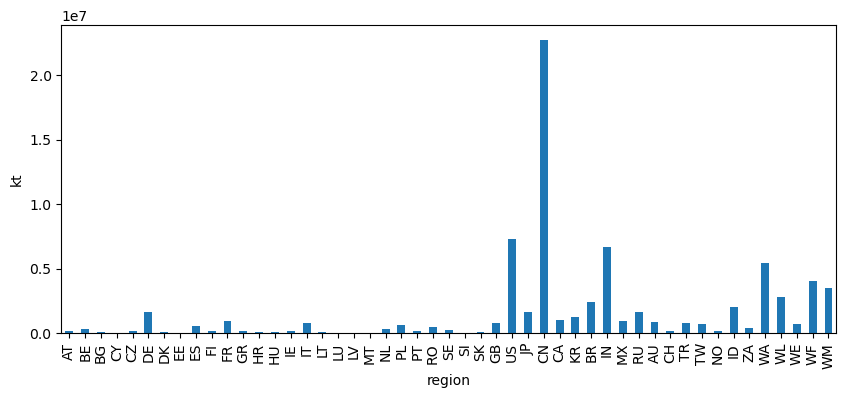

In [14]:
e_ft_materials_regions.plot(
    figsize = (10,4),
    kind = 'bar',
    ylabel = "kt",
)

### Question 2

Identify the top five nations regarding country total MF and per capita MF, respectively, in 2017. Please exclude the five ‘Rest of the world’ regions.

In [15]:
ROW = ['WA', 'WL', 'WE', 'WF', 'WM']
e_ft_materials_regions.drop(index=ROW).nlargest(5)

region
CN   22,774,597.50
US    7,267,069.21
IN    6,683,765.69
BR    2,379,427.51
ID    2,054,787.63
dtype: float64

In [16]:
e_ft_materials_pp_regions = e_ft_materials_regions / population_per_region

print("units in tonnes per capita (instead of kt per capita)\n")
1e3*e_ft_materials_pp_regions.drop(index=ROW).nlargest(5)

units in tonnes per capita (instead of kt per capita)



region
LU   57.97
AU   34.50
IE   31.89
FI   29.29
TW   28.18
dtype: float64

<Axes: xlabel='region', ylabel='tonnes per capita'>

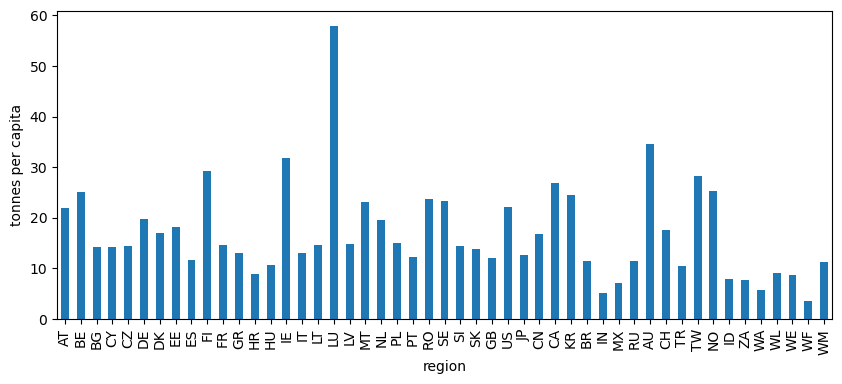

In [17]:
(e_ft_materials_pp_regions*1e3).plot(
    figsize = (10,4),
    kind = 'bar',
    ylabel = "tonnes per capita",
)

### Question 3

Which country/region outsourced the most MF abroad (i.e., had the largest net MF import) in per capita and country total terms, respectively, in 2017?

In [18]:
f_materials_agg = f.loc[MATERIALS].sum(axis=0)  # sum materials consumption to get a vector (pd.Series)

diagfLY_materials_agg = f_materials_agg * LY.T  # = diagf @ L @ Y
diagfLY_materials_agg = diagfLY_materials_agg.T  # retranspose to conserve original layout

# Display intermediary results
diagfLY_materials_agg

region                                                                                             AT  \
category                                                  Final consumption expenditure by households   
region sector                                                                                           
AT     Cultivation of paddy rice                                                                 0.00   
       Cultivation of wheat                                                                    422.93   
       Cultivation of cereal grains nec                                                      1,513.70   
       Cultivation of vegetables, fruit, nuts                                                1,803.11   
       Cultivation of oil seeds                                                                 14.26   
...                                                                                               ...   
WM     Activities of membership organisation n.e.c. (91)                                         0.00   
       Recreational, cultural and sporting activities ...                                        0.01   
       Other service activities (93)                                                             0.00   
       Private households with employed persons (95)                                             6.69   
       Extra-territorial organizations and bodies                                                0.00   

region                                                                                                                                          \
category                                                  Final consumption expenditure by non-profit organisations serving households (NPISH)   
region sector                                                                                                                                    
AT     Cultivation of paddy rice                                                                        0.00                                     
       Cultivation of wheat                                                                             2.81                                     
       Cultivation of cereal grains nec                                                                 5.87                                     
       Cultivation of vegetables, fruit, nuts                                                           0.67                                     
       Cultivation of oil seeds                                                                         0.05                                     
...                                                                                                      ...                                     
WM     Activities of membership organisation n.e.c. (91)                                                0.00                                     
       Recreational, cultural and sporting activities ...                                               0.00                                     
       Other service activities (93)                                                                    0.00                                     
       Private households with employed persons (95)                                                    0.00                                     
       Extra-territorial organizations and bodies                                                       0.00                                     

region                                                                                                 \
category                                                  Final consumption expenditure by government   
region sector                                                                                           
AT     Cultivation of paddy rice                                                                 0.00   
       Cultivation of wheat                                     

In [19]:
# Compute embodied emissions in trade (only keep regions along rows and columns)
embodied_materials_trade = diagfLY_materials_agg.groupby('region', axis=1).sum()
embodied_materials_trade = embodied_materials_trade.groupby('region', axis=0).sum()

# Display intermediary results
embodied_materials_trade

region,AT,AU,BE,BG,BR,CA,CH,CN,CY,CZ,...,SK,TR,TW,US,WA,WE,WF,WL,WM,ZA
region,,,,,,,,,,,,,,,,,,,,,
AT,"82,280.76",305.63,484.65,205.49,357.20,384.24,"1,468.60","2,108.55",14.50,923.14,...,670.63,"1,292.65",135.29,"3,005.82","1,412.84","1,018.74",601.67,753.23,"2,435.74",133.63
AU,"1,894.27","530,817.37","5,652.78",379.97,"12,213.23","13,553.38","2,666.24","699,936.63",141.84,"1,357.28",...,613.56,"12,250.68","42,096.97","129,346.66","172,204.31","3,191.15","22,969.84","34,651.42","65,475.41","4,289.35"
BE,624.78,322.17,"34,626.35",76.60,381.87,469.18,904.81,"3,286.98",29.94,409.64,...,151.63,506.33,102.94,"3,544.05","1,823.87",332.97,"1,741.91",955.37,"3,185.32",214.59
BG,"1,042.09",403.66,"1,049.63","69,434.31",414.02,575.87,446.61,"11,226.55",111.82,555.70,...,345.22,"5,933.24",781.73,"4,531.78","3,963.18","3,508.17","3,439.34","2,315.60","5,737.86","3,376.47"
BR,"1,765.83","4,844.37","7,269.75",285.90,"2,042,143.86","13,307.40","1,956.19","249,616.09",104.93,949.88,...,442.77,"11,653.84","21,662.33","80,316.34","110,158.10","4,757.28","70,149.60","109,478.80","200,101.67","5,483.70"
CA,575.30,"2,764.66","5,525.46",191.16,"4,496.14","569,960.85","1,090.53","73,339.35",35.30,536.94,...,176.14,"2,648.77","5,166.99","330,488.52","24,268.43","1,015.06","7,911.96","23,186.46","14,026.42","3,966.62"
CH,638.37,459.91,820.13,51.68,650.21,"1,021.59","33,982.10","2,696.31",8.45,128.79,...,63.53,369.30,123.15,"6,118.79","2,552.51",282.96,703.47,"1,303.01","3,443.92",127.75
CN,"5,341.31","46,940.90","16,924.97","1,192.74","34,718.52","45,664.79","7,027.14","16,346,567.99",329.12,"4,030.40",...,"2,056.64","25,670.93","6,382.20","386,376.02","498,675.71","12,094.43","103,093.50","137,899.44","201,668.73","13,996.09"
CY,12.30,13.76,24.86,4.68,4.42,13.54,10.93,50.14,"9,133.34",4.06,...,5.11,72.98,3.94,54.98,55.72,22.73,42.63,64.78,228.04,2.66


In [20]:
# Compute imported / exported emissions
exports = embodied_materials_trade.sum(axis=1)  # add columns to get exported emissions
imports = embodied_materials_trade.sum(axis=0)  # add rows to get imported emissions

net_imports = imports - exports

# Net import country total
net_imports.nlargest(5)

region
CN   4,099,970.87
US   1,409,524.32
JP   1,005,805.59
KR     683,542.66
TW     519,139.52
dtype: float64

<Axes: xlabel='region', ylabel='kt'>

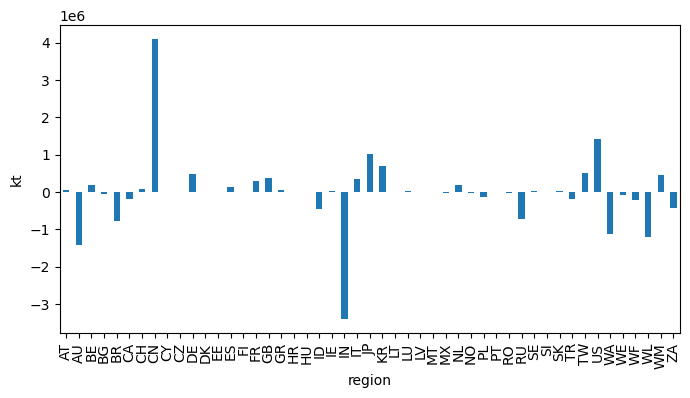

In [21]:
net_imports.plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "kt",
)

In [22]:
# Net import per capita
print("units in tonnes per capita (instead of kt per capita)\n")
1e3*(net_imports / population_per_region).nlargest(5)

units in tonnes per capita (instead of kt per capita)



LU   53.57
TW   21.15
MT   16.90
BE   16.40
KR   13.61
dtype: float64

<Axes: ylabel='kt'>

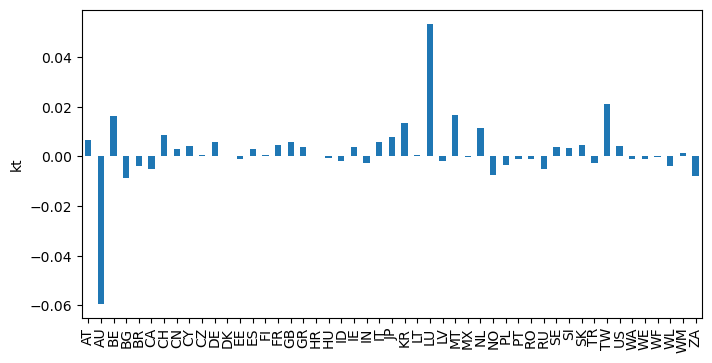

In [23]:
(net_imports / population_per_region).plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "kt",
)

### Question 4

Investments typically play an important role in MF. Among all 49 countries and regions, which one had the highest investment contribution to MF in 2017?

In [24]:
# Select indicator
GFCF = 'Gross fixed capital formation'

In [25]:
Y_column_slice = pd.IndexSlice[:, GFCF]
Y_gfcf = Y.loc[:, Y_column_slice]

fLdiagY_gfcf = (f_materials_agg @ L) * Y_gfcf.T  # Y is a matrix (pd.DataFrame), so f_materials must be a vector (pd.Series)
fLdiagY_gfcf = fLdiagY_gfcf.T  # retranspose to conserve original layout

# Display intermediary results
print("units in tonnes (instead of kt)\n")
1e3*fLdiagY_gfcf

units in tonnes (instead of kt)



region                                                                               AT  \
category                                                  Gross fixed capital formation   
region sector                                                                             
AT     Cultivation of paddy rice                                                   0.00   
       Cultivation of wheat                                                        0.00   
       Cultivation of cereal grains nec                                            0.00   
       Cultivation of vegetables, fruit, nuts                                      0.00   
       Cultivation of oil seeds                                                    0.00   
...                                                                                 ...   
WM     Activities of membership organisation n.e.c. (91)                           7.53   
       Recreational, cultural and sporting activities ...                      3,096.93   
       Other service activities (93)                                              31.25   
       Private households with employed persons (95)                               0.95   
       Extra-territorial organizations and bodies                                  0.00   

region                                                                               BE  \
category                                                  Gross fixed capital formation   
region sector                                                                             
AT     Cultivation of paddy rice                                                   0.00   
       Cultivation of wheat                                                       43.68   
       Cultivation of cereal grains nec                                           64.72   
       Cultivation of vegetables, fruit, nuts                                      0.00   
       Cultivation of oil seeds                                                    0.00   
...                                                                                 ...   
WM     Activities of membership organisation n.e.c. (91)                          27.97   
       Recreational, cultural and sporting activities ...                      2,768.65   
       Other service activities (93)                                             114.92   
       Private households with employed persons (95)                              19.81   
       Extra-territorial organizations and bodies                                  0.00   

region                                                                               BG  \
category                                                  Gross fixed capital formation   
region sector                                                                             
AT     Cultivation of paddy rice                                                   0.00   
       Cultivation of wheat                                                        0.00   
       Cultivation of cereal grains nec                                            0.00   
       Cultivation of vegetables, fruit, nuts                                      0.00   
       Cultivation of oil seeds                                                    0.00   
...                                                                                 ...   
WM     Activities of membership organisation n.e.c. (91)                           0.02   
       Recreational, cultural and sporting activities ...                          0.17   
       Other service activities (93)                                               0.05   
       Private households with employed persons (95)                               0.01   
       Extra-territorial organizations and bodies                                  0.00   

region                                                                               CY  \
category                                                  Gross fixed capital format

In [26]:
# sum rows (i.e. the regional sectors of origins)
fLdiagY_gfcf.sum(axis=0).sort_values(ascending=False)  # don't include F_y for GCFC, only for HH

region  category                     
CN      Gross fixed capital formation   16,898,932.32
US      Gross fixed capital formation    2,764,508.65
WA      Gross fixed capital formation    2,186,106.56
IN      Gross fixed capital formation    2,127,202.31
WM      Gross fixed capital formation    1,344,033.30
WF      Gross fixed capital formation      901,317.78
ID      Gross fixed capital formation      867,582.20
KR      Gross fixed capital formation      740,435.21
JP      Gross fixed capital formation      716,316.89
BR      Gross fixed capital formation      547,617.33
WL      Gross fixed capital formation      534,611.21
DE      Gross fixed capital formation      484,409.04
RU      Gross fixed capital formation      474,866.48
TW      Gross fixed capital formation      389,818.56
CA      Gross fixed capital formation      383,060.54
MX      Gross fixed capital formation      382,199.85
FR      Gross fixed capital formation      353,148.59
AU      Gross fixed capital formation      3

<Axes: xlabel='region', ylabel='%'>

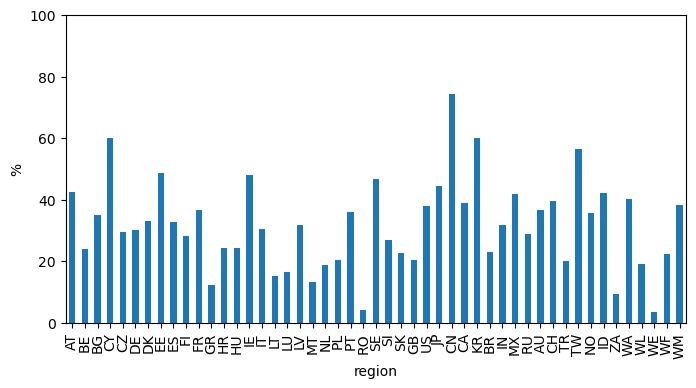

In [27]:
results = fLdiagY_gfcf.sum(axis=0).droplevel(level=1)  # remove "gcfc" from the index

# Per capita
results / population_per_region

# In % of total Material Footprint
(100 * results / e_ft_materials_regions).plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "%",
    ylim=(0, 100),
)

### Question 5

For the country/region identified above, can you further elaborate on how its investment in 2017 drove up its MF? E.g., what kind of investment (see the sectoral results), whether the MF were domestic or abroad, the compositions of the four type of materials, etc.)

In [28]:
# Get material clusters
MASK = f.index.str.contains("Domestic Extraction Used - Fossil Fuel")
FF = f.loc[MASK].index

MASK = f.index.str.contains("Domestic Extraction Used - Metal Ores")
METALS = f.loc[MASK].index

MASK = f.index.str.contains("Domestic Extraction Used - Non-Metallic Minerals")
MINERALS = f.loc[MASK].index

MASK = set(MATERIALS.tolist()) - set(FF.to_list()) - set(METALS.to_list()) - set(MINERALS.tolist())
BIOMASS = f.loc[list(MASK)].index

# cluster relevant stressors together
clusters_stressors = {
    'Fossil Fuels': FF,
    'Metals' : METALS,
    'Minerals' : MINERALS,
    'Biomass' : BIOMASS,
}

# Sanity check
# Ensure all indicators are divided
if len(FF) + len(METALS) + len(MINERALS) + len(BIOMASS) != len(MATERIALS):
    raise ValueError("Missing indicators from 'Domestic Extraction Used")

# Ensure clusters don't overlap
for (cluster1, cluster2) in list(combinations([FF, METALS, MINERALS, BIOMASS], r=2)):
    intersect = cluster1.intersection(cluster2)
    if len(intersect) > 0:
        raise ValueError(f"{intersect} is in more than one cluster")
    
#  make sure all the indicators have the same unit
F_unit.loc[MATERIALS]['unit'].unique()

array(['kt'], dtype=object)

In [29]:
country = 'CN'
Y_column_slice = pd.IndexSlice[country, GFCF]

f_materials = f.loc[MATERIALS]
diagfLY_materials_gfcf_CN = f_materials * LY.loc[:, Y_column_slice]  # f * L @ Y = diag(f) @ L @ Y
diagfLY_materials_gfcf_CN = diagfLY_materials_gfcf_CN.T  # retranspose to conserve original layout

# Display intermediary result
print("units in kg (instead of kt)\n")
1e6*diagfLY_materials_gfcf_CN

units in kg (instead of kt)



stressor                                                   Domestic Extraction Used - Crop residues - Feed  \
region sector                                                                                                
AT     Cultivation of paddy rice                                                                      0.00   
       Cultivation of wheat                                                                           0.00   
       Cultivation of cereal grains nec                                                               0.00   
       Cultivation of vegetables, fruit, nuts                                                         0.00   
       Cultivation of oil seeds                                                                       0.00   
...                                                                                                    ...   
WM     Activities of membership organisation n.e.c. (91)                                              3.16   
       Recreational, cultural and sporting activities ...                                             1.29   
       Other service activities (93)                                                                  0.27   
       Private households with employed persons (95)                                                  0.01   
       Extra-territorial organizations and bodies                                                     0.00   

stressor                                                   Domestic Extraction Used - Crop residues - Straw  \
region sector                                                                                                 
AT     Cultivation of paddy rice                                                                       0.00   
       Cultivation of wheat                                                                            0.00   
       Cultivation of cereal grains nec                                                                0.00   
       Cultivation of vegetables, fruit, nuts                                                          0.00   
       Cultivation of oil seeds                                                                        0.00   
...                                                                                                     ...   
WM     Activities of membership organisation n.e.c. (91)                                               2.50   
       Recreational, cultural and sporting activities ...                                              1.01   
       Other service activities (93)                                                                   0.21   
       Private households with employed persons (95)                                                   0.01   
       Extra-territorial organizations and bodies                                                      0.00   

stressor                                                   Domestic Extraction Used - Fishery - Aquatic plants  \
region sector                                                                                                    
AT     Cultivation of paddy rice                                                                        0.00     
       Cultivation of wheat                                                                             0.00     
       Cultivation of cereal grains nec                                                                 0.00     
       Cultivation of vegetables, fruit, nuts                                                           0.00     
       Cultivation of oil seeds                                                                         0.00     
...                                                                                                      ...     
WM     Activities of membership organisation n.e.c. (91)                                                0.00     
       Recreational, cultural and sporting activities ...                                          

In [30]:
# create empty dataframe
Material_Footprint_CN_gcfc = pd.DataFrame(
    data=np.nan, 
    index=region_and_sector_labels, 
    columns=clusters_stressors.keys()
)

# and fill it
for cluster, stressors in clusters_stressors.items():
    Material_Footprint_CN_gcfc.loc[:, cluster] = diagfLY_materials_gfcf_CN.loc[:, stressors].sum(axis=1)

# Display results
print("units in kg (instead of kt)\n")
1e6*Material_Footprint_CN_gcfc

units in kg (instead of kt)



Fossil Fuels  \
region sector                                                             
AT     Cultivation of paddy rice                                   0.00   
       Cultivation of wheat                                        0.00   
       Cultivation of cereal grains nec                            0.00   
       Cultivation of vegetables, fruit, nuts                      0.00   
       Cultivation of oil seeds                                    0.00   
...                                                                 ...   
WM     Activities of membership organisation n.e.c. (91)           0.00   
       Recreational, cultural and sporting activities ...         66.23   
       Other service activities (93)                               0.00   
       Private households with employed persons (95)              21.17   
       Extra-territorial organizations and bodies                  0.00   

                                                           Metals  \
region sector                                                       
AT     Cultivation of paddy rice                             0.00   
       Cultivation of wheat                                  0.00   
       Cultivation of cereal grains nec                      0.00   
       Cultivation of vegetables, fruit, nuts                0.00   
       Cultivation of oil seeds                              0.00   
...                                                           ...   
WM     Activities of membership organisation n.e.c. (91)     0.00   
       Recreational, cultural and sporting activities ...    0.20   
       Other service activities (93)                         0.00   
       Private households with employed persons (95)         0.75   
       Extra-territorial organizations and bodies            0.00   

                                                              Minerals  \
region sector                                                            
AT     Cultivation of paddy rice                                  0.00   
       Cultivation of wheat                                       0.00   
       Cultivation of cereal grains nec                           0.00   
       Cultivation of vegetables, fruit, nuts                     0.00   
       Cultivation of oil seeds                                   0.00   
...                                                                ...   
WM     Activities of membership organisation n.e.c. (91)          0.00   
       Recreational, cultural and sporting activities ...   140,116.55   
       Other service activities (93)                              0.00   
       Private households with employed persons (95)      5,259,722.21   
       Extra-territorial organizations and bodies                 0.00   

                                                                Biomass  
region sector                                                            
AT     Cultivation of paddy rice                                   0.00  
       Cultivation of wheat                                5,551,986.08  
       Cultivation of cereal grains nec                   12,394,695.83  
       Cultivation of vegetables, fruit, nuts              1,468,695.79  
       Cultivation of oil seeds                            3,120,529.44  
...                                                                 ...  
WM     Activities of membership organisation n.e.c. (91)       6,215.25  
       Recreational, cultural and sporting activities ...          7.45  
       Other service activities (93)                               1.45  
       Private households with employed persons (95)             662.28  
       Extra-territorial organizations and bodies                  0.00  

[7987 rows x 4 columns]

In [31]:
# Display total for each cluster
Material_Footprint_CN_gcfc.sum(axis=0)

Fossil Fuels    2,229,117.13
Metals          2,532,464.22
Minerals       10,268,769.15
Biomass         1,868,581.82
dtype: float64

In [32]:
# For each type of materials, check the top contributors (sectors + regions)
for cluster in clusters_stressors.keys():
    print(f"\n{cluster}:\n{Material_Footprint_CN_gcfc[cluster].nlargest(10)}")


Fossil Fuels:
region  sector                                                                                         
CN      Mining of coal and lignite; extraction of peat (10)                                               1,591,271.79
WA      Mining of coal and lignite; extraction of peat (10)                                                  74,677.33
AU      Mining of coal and lignite; extraction of peat (10)                                                  74,156.58
CN      Extraction of crude petroleum and services related to crude oil extraction, excluding surveying      68,748.58
ID      Mining of coal and lignite; extraction of peat (10)                                                  64,713.01
WM      Extraction of crude petroleum and services related to crude oil extraction, excluding surveying      61,183.56
RU      Extraction of crude petroleum and services related to crude oil extraction, excluding surveying      38,014.20
WA      Extraction of natural gas and services r

array([<Axes: ylabel='Fossil Fuels'>, <Axes: ylabel='Metals'>,
       <Axes: ylabel='Minerals'>, <Axes: ylabel='Biomass'>], dtype=object)

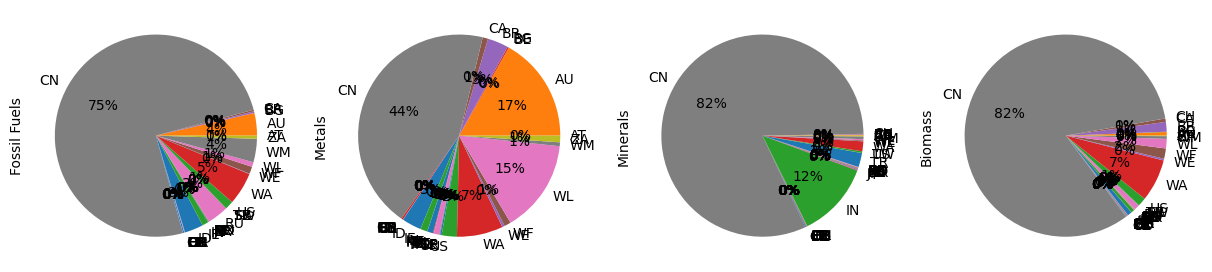

In [33]:
Material_Footprint_by_regions_CN_gcfc = Material_Footprint_CN_gcfc.groupby('region', axis=0).sum()

Material_Footprint_by_regions_CN_gcfc.plot(
    subplots=True,
    figsize = (15,15),
    kind = 'pie',
    autopct = '%1.0f%%',
    legend=False,
)

<Axes: title={'center': 'Metals'}, ylabel='Metals'>

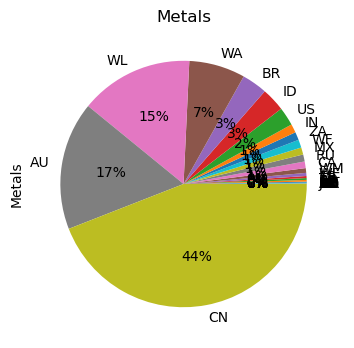

In [34]:
# To show a specific cluster
cluster = 'Metals'  # "Fossil Fuels" , "Metals", "Minerals", "Biomass"
Material_Footprint_by_regions_CN_gcfc[cluster].sort_values().plot(
    title=cluster,
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

In [35]:
Material_Footprint_by_sectors_CN_gcfc = Material_Footprint_CN_gcfc.groupby('sector', axis=0).sum()

# cluster relevant sectors together
# ! Be careful, it's different from ixi (163 sectors) vs pxp (200 sectors)
clusters_sectors = {
    'agriculture' : sector_labels[0:18],
    'mining' : sector_labels[19:33],
    'manufacturing': sector_labels[34:114],
    'service': sector_labels[115:163],
}

# create empty dataframe
Material_Footprint_by_agg_sectors_CN_gcfc = pd.DataFrame(
    data=np.nan, 
    index=clusters_sectors.keys(), 
    columns=clusters_stressors.keys()
)

# and fill it
for cluster, sectors in clusters_sectors.items():
    Material_Footprint_by_agg_sectors_CN_gcfc.loc[cluster] = Material_Footprint_by_sectors_CN_gcfc.loc[sectors].sum()

# Display results
Material_Footprint_by_agg_sectors_CN_gcfc

,Fossil Fuels,Metals,Minerals,Biomass
agriculture,270.87,128.96,"2,122.10","1,865,810.41"
mining,"2,227,333.40","2,528,819.68","10,190,570.99",75.44
manufacturing,719.91,"2,387.75","12,220.22",670.97
service,748.08,"1,036.16","2,014.12",338.24


<Axes: xlabel='kt'>

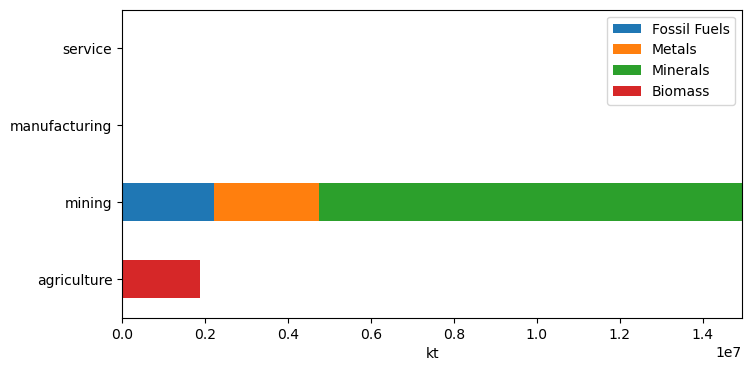

In [36]:
Material_Footprint_by_agg_sectors_CN_gcfc.plot(
    figsize = (8,4),
    kind = 'barh',
    stacked=True,
    xlabel='kt',
)

### For fun

Quantify the material footprint (MF) of the nations by type (biomass, fossil fuels, metal ores, minerals)

In [37]:
countries = region_labels

# create multi index for a new DataFrame
column_labels = pd.MultiIndex.from_product(
    iterables=[countries, MATERIALS], 
    names=['region', 'stressor']
)

# create empty pd.DataFrame
diagfLY_materials_countries = pd.DataFrame(
    data=np.nan, 
    index=region_and_sector_labels, 
    columns=column_labels
)

# Multiple indicators x 1 country at a time
for country in countries:
    LY_1country = LY.loc[:, country].sum(axis=1)
    diagfLY_ghg_1country = f_materials * LY_1country.T  # ! the right side of * needs to be transposed if it contains multiple columns
    diagfLY_ghg_1country = diagfLY_ghg_1country.T  # retranspose to conserve original layout
    diagfLY_materials_countries.loc[:, country] = diagfLY_ghg_1country.values

# Display intermediary results
print("units in kg (instead of kt)\n")
1e6*diagfLY_materials_countries

units in kg (instead of kt)



region                                                                                                 AT  \
stressor                                                  Domestic Extraction Used - Crop residues - Feed   
region sector                                                                                               
AT     Cultivation of paddy rice                                                                     0.00   
       Cultivation of wheat                                                                          0.00   
       Cultivation of cereal grains nec                                                              0.00   
       Cultivation of vegetables, fruit, nuts                                                        0.00   
       Cultivation of oil seeds                                                                      0.00   
...                                                                                                   ...   
WM     Activities of membership organisation n.e.c. (91)                                             1.27   
       Recreational, cultural and sporting activities ...                                            0.33   
       Other service activities (93)                                                                 0.04   
       Private households with employed persons (95)                                                 0.01   
       Extra-territorial organizations and bodies                                                    0.00   

region                                                                                                      \
stressor                                                  Domestic Extraction Used - Crop residues - Straw   
region sector                                                                                                
AT     Cultivation of paddy rice                                                                      0.00   
       Cultivation of wheat                                                                           0.00   
       Cultivation of cereal grains nec                                                               0.00   
       Cultivation of vegetables, fruit, nuts                                                         0.00   
       Cultivation of oil seeds                                                                       0.00   
...                                                                                                    ...   
WM     Activities of membership organisation n.e.c. (91)                                              1.00   
       Recreational, cultural and sporting activities ...                                             0.26   
       Other service activities (93)                                                                  0.03   
       Private households with employed persons (95)                                                  0.01   
       Extra-territorial organizations and bodies                                                     0.00   

region                                                                                                         \
stressor                                                  Domestic Extraction Used - Fishery - Aquatic plants   
region sector                                                                                                   
AT     Cultivation of paddy rice                                                                        0.00    
       Cultivation of wheat                                                                             0.00    
       Cultivation of cereal grains nec                                                                 0.00    
       Cultivation of vegetables, fruit, nuts                                                           0.00    
       Cultivation of oil seeds                                                                         0.00    
...                         

In [39]:
# create multi index for a new DataFrame
column_labels = pd.MultiIndex.from_product(
    iterables=[countries, clusters_stressors.keys()],
    names=['region', 'stressor']
)

# create empty pd.DataFrame
diagfLY_agg_materials_countries = pd.DataFrame(
    data=np.nan,
    index=region_and_sector_labels,
    columns=column_labels
)

# reverse the clusters > indexes (so that each index points to the cluster it belongs to)
inverse_clusters_stressors = {stressor: cluster for cluster, stressors in clusters_stressors.items() for stressor in stressors}

# Multiple indicators x 1 country at a time
for country in countries:
    data = diagfLY_materials_countries[country].T
    data = data.groupby(inverse_clusters_stressors).sum()
    diagfLY_agg_materials_countries.loc[:, country] = data.T.values

# Display intermediary results
print("units in tonnes (instead of kt)\n")
1e3*diagfLY_agg_materials_countries

units in tonnes (instead of kt)



region                                                              AT         \
stressor                                                  Fossil Fuels Metals   
region sector                                                                   
AT     Cultivation of paddy rice                                  0.00   0.00   
       Cultivation of wheat                                 511,263.61   0.00   
       Cultivation of cereal grains nec                   1,679,728.35   0.00   
       Cultivation of vegetables, fruit, nuts             1,848,941.70   0.00   
       Cultivation of oil seeds                              15,480.25   0.00   
...                                                                ...    ...   
WM     Activities of membership organisation n.e.c. (91)          2.50   0.00   
       Recreational, cultural and sporting activities ...         0.00   0.02   
       Other service activities (93)                              0.00   0.00   
       Private households with employed persons (95)              0.86   0.03   
       Extra-territorial organizations and bodies                 0.00   0.00   

region                                                                       \
stressor                                                  Minerals  Biomass   
region sector                                                                 
AT     Cultivation of paddy rice                              0.00     0.00   
       Cultivation of wheat                                   0.00     0.00   
       Cultivation of cereal grains nec                       0.00     0.00   
       Cultivation of vegetables, fruit, nuts                 0.00     0.00   
       Cultivation of oil seeds                               0.00     0.00   
...                                                            ...      ...   
WM     Activities of membership organisation n.e.c. (91)      0.00     0.00   
       Recreational, cultural and sporting activities ...     0.00    35.44   
       Other service activities (93)                          0.00     0.00   
       Private households with employed persons (95)          0.00 6,823.74   
       Extra-territorial organizations and bodies             0.00     0.00   

region                                                              BE         \
stressor                                                  Fossil Fuels Metals   
region sector                                                                   
AT     Cultivation of paddy rice                                  0.00   0.00   
       Cultivation of wheat                                   7,852.44   0.00   
       Cultivation of cereal grains nec                      16,109.66   0.00   
       Cultivation of vegetables, fruit, nuts                 4,032.95   0.00   
       Cultivation of oil seeds                               4,180.77   0.00   
...                                                                ...    ...   
WM     Activities of membership organisation n.e.c. (91)          6.16   0.00   
       Recreational, cultural and sporting activities ...         0.00   0.04   
       Other service activities (93)                              0.00   0.00   
       Private households with employed persons (95)              2.15   0.07   
       Extra-territorial organizations and bodies                 0.00   0.00   

region                                                                        \
stressor                                                  Minerals   Biomass   
region sector                                                                  
AT     Cultivation of paddy rice                              0.00      0.00   
       Cultivation of wheat                                   0.00      0.00   
       Cultivation of cereal grains nec                       0.00      0.00   
       Cultivation of vegetables, fruit, nuts                 0.00      0.00   
       Cultivation of oil seeds                               0

In [40]:
Material_Footprint_by_type = diagfLY_agg_materials_countries.sum(axis=0).unstack()
Material_Footprint_by_type

stressor,Biomass,Fossil Fuels,Metals,Minerals
region,,,,
AT,"99,083.63","52,495.15","22,030.55","12,842.49"
AU,"181,290.63","202,770.58","257,685.25","188,655.04"
BE,"122,183.84","82,846.92","49,755.41","25,076.11"
BG,"44,232.99","29,562.11","20,889.23","4,868.62"
BR,"445,740.93","1,717,180.84","138,217.55","78,288.20"
CA,"395,146.41","275,167.68","179,909.92","132,465.50"
CH,"67,325.50","39,848.04","24,809.18","15,207.98"
CN,"11,751,038.70","4,821,065.04","3,166,755.30","3,035,738.45"
CY,"11,955.92","2,683.98","1,560.79",775.24


<Axes: xlabel='region', ylabel='kt'>

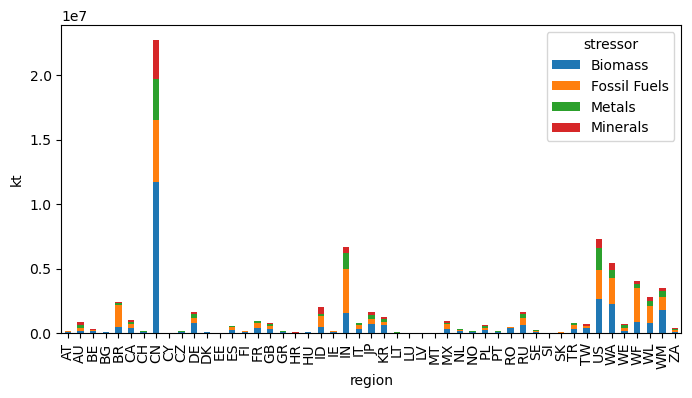

In [41]:
Material_Footprint_by_type.plot(
    figsize = (8,4),
    kind = 'bar',
    stacked=True,
    ylabel="kt"
)

<Axes: ylabel='tonnes per capita'>

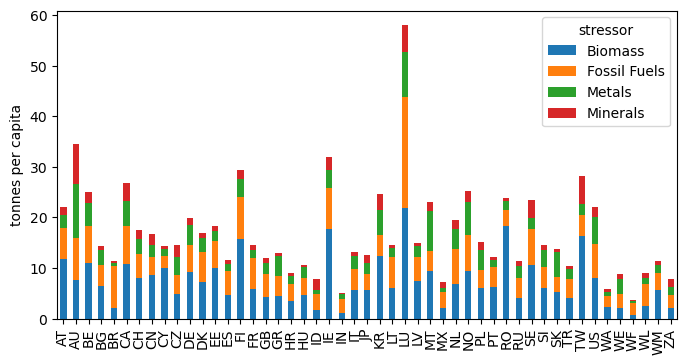

In [42]:
# Divide by the population along each column
Material_Footprint_pp_by_type = Material_Footprint_by_type.divide(population_per_region, axis=0)

(Material_Footprint_pp_by_type*1e3).plot(
    figsize = (8,4),
    kind = 'bar',
    stacked=True,
    ylabel="tonnes per capita"
)

## Exercise 2

Please donwload and use exiobase’s 2019 MRIO data (product by product) Make sure you locate to exiobase’ latest version on Zenodo.

In [43]:
dir_path = "../data/exiobase/_pxp/IOT_2019_pxp/"

In [44]:
# Import A, Y, F and F_Y (from SATELLITE)
# ! 'A' is a large datasets, mind load time
A = pd.read_csv(f'{dir_path}A.txt', delimiter="\t", header=[0,1], index_col=[0,1])
Y = pd.read_csv(f'{dir_path}Y.txt', delimiter="\t", header=[0,1], index_col=[0,1])
# ! we use the satellite folder this time because we will look at uncharacterized stressors (CO2 emission vs GWP100)
F = pd.read_csv(f'{dir_path}satellite/F.txt', delimiter="\t", header=[0,1], index_col=[0])
F_y = pd.read_csv(f'{dir_path}satellite/F_Y.txt', delimiter="\t", header=[0,1], index_col=[0])
F_unit = pd.read_csv(f'{dir_path}satellite/unit.txt', delimiter="\t", header=0, index_col=[0])

In [45]:
# get multiindex
region_and_sector_labels = A.index

# get each level using  'get_level_values()'
region_labels = A.index.get_level_values(level=0).unique()
sector_labels = A.index.get_level_values(level=1).unique()

In [46]:
# Create an identity matrix the same order
Id = np.identity(len(region_and_sector_labels))

# Compute leontief inverse matrix in the Demand-pull model
L_values = np.linalg.inv((Id - A))
L = pd.DataFrame(
    data=L_values, 
    index=region_and_sector_labels, 
    columns=region_and_sector_labels
)

# we also save LY to avoid repeating calculations
LY = L @ Y

# Compute x using L
x = LY.sum(axis=1)

# compute extension intensity
f = F / x.T
f = f.replace([np.inf, -np.inf, np.nan], 0)  # ! don't forget to replace

### Question 1

Quantify the territorial CO2 emissions and CO2 footprint of regions in 2019.

In [47]:
# select extension indicator
MASK = f.index.str.contains("CO2")
CO2 = f.loc[MASK].index
CO2

Index(['CO2 - combustion - air',
       'CO2 - non combustion - Cement production - air',
       'CO2 - non combustion - Lime production - air',
       'CO2 - agriculture - peat decay - air', 'CO2 - waste - biogenic - air',
       'CO2 - waste - fossil - air'],
      dtype='object', name='stressor')

In [48]:
# CO2 footprint per region (total)
f_co2 = f.loc[CO2]
F_y_co2 = F_y.loc[CO2]
fLY_co2 = f_co2 @ LY

e_fp_co2 = fLY_co2 + F_y_co2

# Sanity check
# if not (fLY_co2.shape == F_y_co2.shape):
#     raise IndexError("shape error")

# Uncomment to display result
e_fp_co2

region                                                                                  AT  \
category                                       Final consumption expenditure by households   
stressor                                                                                     
CO2 - combustion - air                                                   53,349,751,186.52   
CO2 - non combustion - Cement production - air                              426,405,439.73   
CO2 - non combustion - Lime production - air                                170,984,934.57   
CO2 - agriculture - peat decay - air                                        189,588,509.40   
CO2 - waste - biogenic - air                                                 10,195,721.41   
CO2 - waste - fossil - air                                                      334,080.05   

region                                                                                                                               \
category                                       Final consumption expenditure by non-profit organisations serving households (NPISH)   
stressor                                                                                                                              
CO2 - combustion - air                                                           1,558,291,018.70                                     
CO2 - non combustion - Cement production - air                                      20,711,458.49                                     
CO2 - non combustion - Lime production - air                                         8,701,658.53                                     
CO2 - agriculture - peat decay - air                                                   608,199.04                                     
CO2 - waste - biogenic - air                                                           168,435.41                                     
CO2 - waste - fossil - air                                                               4,452.31                                     

region                                                                                      \
category                                       Final consumption expenditure by government   
stressor                                                                                     
CO2 - combustion - air                                                    7,021,578,753.13   
CO2 - non combustion - Cement production - air                              115,329,862.97   
CO2 - non combustion - Lime production - air                                 46,403,010.44   
CO2 - agriculture - peat decay - air                                          6,924,245.31   
CO2 - waste - biogenic - air                                                  1,545,366.09   
CO2 - waste - fossil - air                                                       45,236.78   

region                                                                        \
category                                       Gross fixed capital formation   
stressor                                                                       
CO2 - combustion - air                                     18,657,598,016.97   
CO2 - non combustion - Cement production - air              1,533,878,154.22   
CO2 - non combustion - Lime production - air                  630,382,528.13   
CO2 - agriculture - peat decay - air                           15,642,367.74   
CO2 - waste - biogenic - air                                    8,460,064.20   
CO2 - waste - fossil - air                                        304,640.12   

region                                                                 \
category                                       Changes in inventories   
stressor                                                                
CO2 - combustion - air                               1,018,775,833.07   
CO2 - non combustion - Cement production - air          19,704,512.13   
CO2 

In [49]:
# Keep regions (column level 0) and sum accross categories (column level 1)
e_fp_co2_regions = e_fp_co2.groupby('region', axis=1).sum()
e_fp_co2_regions = e_fp_co2_regions.reindex(columns=region_labels)  # groupby() reshuffles, so apply reindex()

e_fp_co2_regions

region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
stressor,,,,,,,,,,,,,,,,,,,,,
CO2 - combustion - air,"81,605,994,808.39","124,314,302,960.14","27,984,409,451.63","8,481,758,399.64","98,580,247,884.89","839,092,371,286.41","62,137,897,139.81","12,928,567,387.39","260,029,414,631.69","50,762,379,209.82",...,"369,308,180,790.60","201,433,301,344.22","65,380,652,873.31","538,168,095,650.05","254,985,318,608.15","2,190,803,422,805.65","784,273,071,218.70","331,893,924,371.60","932,874,949,033.55","2,016,090,147,902.37"
CO2 - non combustion - Cement production - air,"2,116,029,427.54","3,204,432,616.97","1,305,892,705.84","872,252,586.66","1,506,497,059.59","16,682,597,289.19","1,291,751,868.90","300,021,223.74","8,817,572,670.86","991,283,479.08",...,"15,664,948,713.44","4,582,358,471.63","1,310,185,410.59","35,591,622,473.98","5,798,970,701.30","79,659,543,365.55","35,351,955,485.57","8,516,602,962.42","75,086,952,322.81","94,224,594,425.40"
CO2 - non combustion - Lime production - air,"864,353,950.27","2,718,711,824.25","495,314,587.93","172,411,327.91","717,156,474.00","6,177,681,030.65","319,459,192.63","60,874,403.44","1,241,878,412.94","350,210,064.69",...,"3,076,883,299.36","829,689,495.66","353,893,343.97","3,350,135,774.62","2,165,626,487.74","22,753,038,266.81","15,155,857,059.32","8,332,096,364.96","13,414,275,691.12","18,077,785,725.66"
CO2 - agriculture - peat decay - air,"216,850,014.39","264,217,403.78","49,586,139.36","14,802,927.21","121,247,259.94","2,697,051,026.20","128,361,952.64","11,311,086.73","795,459,726.97","229,574,842.59",...,"2,752,696,280.28","1,447,776,562.43","83,754,075.42","2,750,279,898.97","253,523,157.41","2,624,395,944.25","951,089,733.09","173,715,524.33","1,125,531,898.38","6,641,711,523.66"
CO2 - waste - biogenic - air,"20,862,464.72","42,840,119.83","7,211,432.07","820,195.49","408,903,020.15","208,254,914.71","14,587,193.25","1,960,733.23","2,750,475,361.65","11,429,943.31",...,"28,047,454.38","16,820,960.07","27,640,660.38","200,316,366.74","9,411,740.98","469,378,307.94","197,031,064.46","66,608,928.55","124,545,500.48","134,879,994.87"
CO2 - waste - fossil - air,"703,952.39","2,173,716.03","272,389.91","35,192.42","9,191,528.97","7,986,170.34","715,168.60","81,732.01","40,905,766.09","426,165.73",...,"1,352,993.66","1,295,347.52","681,066.67","2,308,658.06","513,984.08","52,414,131.79","9,700,448.57","1,960,554.32","6,095,980.98","6,859,547.77"


In [50]:
# aggregate CO2 extensions
e_fp_agg_co2_regions = e_fp_co2_regions.sum(axis=0)

# Display result 
e_fp_agg_co2_regions

region
AT      84,824,794,617.69
BE     130,546,678,640.99
BG      29,842,686,706.74
CY       9,542,080,629.34
CZ     101,343,243,227.54
DE     864,865,941,717.49
DK      63,892,772,515.83
EE      13,302,816,566.54
ES     273,675,706,570.20
FI      52,345,303,705.23
FR     435,922,918,881.56
GR     128,204,409,564.73
HR      19,340,422,907.48
HU      59,159,430,880.38
IE      68,342,556,759.48
IT     421,519,507,220.93
LT      18,216,381,977.55
LU      11,720,705,114.68
LV      11,466,152,122.31
MT       4,265,164,057.86
NL     179,416,124,947.43
PL     296,324,109,780.04
PT      55,881,949,317.46
RO      78,887,359,806.44
SE      66,329,618,922.15
SI      15,602,066,963.49
SK      39,485,753,190.42
GB     528,648,925,974.40
US   5,762,732,109,324.72
JP   1,192,101,106,240.40
CN   9,947,220,866,048.99
CA     504,036,160,544.95
KR     686,579,834,934.05
BR     454,115,296,774.87
IN   2,345,060,988,636.48
MX     426,575,193,905.37
RU   1,183,685,224,399.73
AU     430,496,623,588.77
CH   

<Axes: xlabel='region', ylabel='kt CO2'>

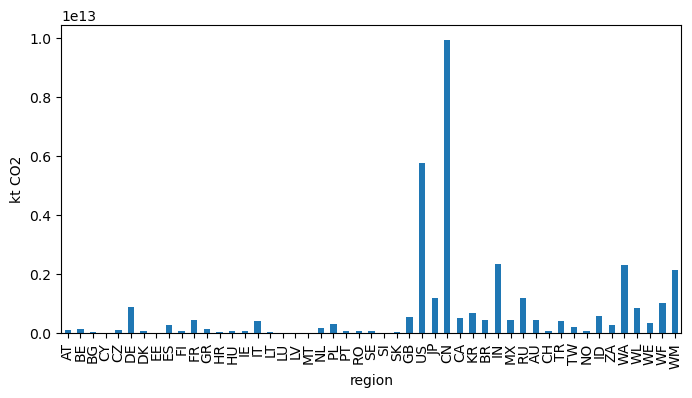

In [51]:
# Visualize
(e_fp_agg_co2_regions).plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "kt CO2",
)

# Check units are indeed in kg
# F_unit.loc[CO2]

In [65]:
# compute production based emissions
diagfX_co2 = f_co2 * x  # f * x = np.diag(f) @ x

# Display intermediary result
diagfX_co2

region                                                 AT                 \
sector                                         Paddy rice          Wheat   
stressor                                                                   
CO2 - combustion - air                               0.00 229,860,338.19   
CO2 - non combustion - Cement production - air       0.00           0.00   
CO2 - non combustion - Lime production - air         0.00           0.00   
CO2 - agriculture - peat decay - air                 0.00  21,572,911.22   
CO2 - waste - biogenic - air                         0.00           0.00   
CO2 - waste - fossil - air                           0.00           0.00   

region                                                            \
sector                                         Cereal grains nec   
stressor                                                           
CO2 - combustion - air                            228,239,802.62   
CO2 - non combustion - Cement production - air              0.00   
CO2 - non combustion - Lime production - air                0.00   
CO2 - agriculture - peat decay - air               34,455,387.04   
CO2 - waste - biogenic - air                                0.00   
CO2 - waste - fossil - air                                  0.00   

region                                                                  \
sector                                         Vegetables, fruit, nuts   
stressor                                                                 
CO2 - combustion - air                                  106,626,375.49   
CO2 - non combustion - Cement production - air                    0.00   
CO2 - non combustion - Lime production - air                      0.00   
CO2 - agriculture - peat decay - air                      9,057,874.57   
CO2 - waste - biogenic - air                                      0.00   
CO2 - waste - fossil - air                                        0.00   

region                                                        \
sector                                             Oil seeds   
stressor                                                       
CO2 - combustion - air                         49,787,015.08   
CO2 - non combustion - Cement production - air         45.75   
CO2 - non combustion - Lime production - air           18.66   
CO2 - agriculture - peat decay - air           11,268,750.04   
CO2 - waste - biogenic - air                            0.00   
CO2 - waste - fossil - air                              0.00   

region                                                                 \
sector                                         Sugar cane, sugar beet   
stressor                                                                
CO2 - combustion - air                                  12,844,898.81   
CO2 - non combustion - Cement production - air                   0.00   
CO2 - non combustion - Lime production - air                     0.00   
CO2 - agriculture - peat decay - air                     2,880,329.69   
CO2 - waste - biogenic - air                                     0.00   
CO2 - waste - fossil - air                                       0.00   

region                                                             \
sector                                         Plant-based fibers   
stressor                                                            
CO2 - combustion - air                                  10,930.59   
CO2 - non combustion - Cement production - air               0.00   
CO2 - non combustion - Lime production - air                 0.00   
CO2 - agriculture - peat decay - air                    33,560.87   
CO2 - waste - biogenic - air                                 0.00   
CO2 - waste - fossil - air                                   0.00   

region                                                                      \
sector                                             Crops nec        Cattle   
stressor              

In [52]:
# compute territorial emissions
e_territorial_co2_regions =  diagfX_co2.groupby('region', axis=1).sum() + F_y_co2.groupby('region', axis=1).sum()  

# ! diagfX + F_y --> WRONG !! We need to aggregate diagfX first
# if not (diagfX_co2.shape == F_y_co2.shape):
    # raise IndexError("shape error")

# Uncomment to display result
e_territorial_co2_regions

region,AT,AU,BE,BG,BR,CA,CH,CN,CY,CZ,...,SK,TR,TW,US,WA,WE,WF,WL,WM,ZA
stressor,,,,,,,,,,,,,,,,,,,,,
CO2 - combustion - air,"63,837,362,963.85","408,073,521,045.63","94,962,704,327.04","37,056,660,354.69","413,831,063,725.12","563,452,939,793.91","43,142,732,895.30","9,770,837,170,996.11","12,491,545,189.19","98,734,204,605.44",...,"28,893,855,001.66","382,316,260,862.27","268,782,209,174.22","4,904,516,011,664.88","2,069,286,402,107.00","320,348,347,680.37","701,907,806,434.91","729,964,938,074.77","2,221,300,265,437.33","394,166,798,033.24"
CO2 - non combustion - Cement production - air,"1,684,253,656.11","2,937,792,171.70","2,348,778,101.91","1,214,267,690.72","18,254,211,874.85","8,279,159,409.02","1,968,519,217.91","784,604,021,479.00","829,301,279.59","1,751,331,103.26",...,"1,437,245,210.25","40,577,976,624.72","4,700,917,793.58","44,650,273,318.56","121,552,188,967.27","10,357,660,577.91","58,978,991,734.74","30,365,059,958.52","107,790,043,440.72","5,322,105,204.32"
CO2 - non combustion - Lime production - air,"687,001,486.34","877,126,761.62","3,395,280,136.53","564,164,854.02","8,599,950,759.25","3,473,585,445.21","131,527,200.82","256,124,899,584.00","162,016,704.45","883,309,111.20",...,"825,182,667.72","7,571,869,063.73","403,129,480.46","28,667,395,824.59","35,829,933,541.74","12,286,304,987.08","9,411,328,884.28","14,223,867,338.33","20,011,473,098.07","2,225,321,432.72"
CO2 - agriculture - peat decay - air,"199,538,068.60","3,314,584,872.65","44,861,878.98","35,471,291.25","18,186,015,962.26","1,289,389,910.63","3,071,677.81","10,878,660,678.92","12,373,503.76","87,736,004.19",...,"20,250,826.20","3,286,450,375.76","1,223,308,031.55","8,991,716,456.68","6,837.54","1,154.23","1,372.80","4,353.74","6,427,238,409.26","262,696,925.32"
CO2 - waste - biogenic - air,"184,811.19","11,453,960.87","1,637,687.55","5,416,396.51","305,996,124.86","219,514,079.08","8,849,682.78","2,017,874,283.63",0.00,"513,882,250.55",...,"10,257,708.78","906,511.38",0.60,0.00,"307,117,776.57","51,886,462.96","18,458,625.76","161,751,867.73","445,189.62",0.00
CO2 - waste - fossil - air,290.86,"64,443.16","16,238.14","207,587.21","11,992,750.31","7,657,172.70","22,229.00","125,754,885.39",0.00,"11,527,192.96",...,"551,101.66","46,821.97",0.60,0.00,"80,214,727.83","1,376,074.15","1,378,737.87","8,803,740.76","11,884.09",0.00


In [53]:
# aggregate CO2 extensions
e_territorial_agg_co2_regions = e_territorial_co2_regions.sum(axis=0)

# Display result 
e_territorial_agg_co2_regions

region
AT       66,408,341,276.94
AU      415,214,543,255.63
BE      100,753,278,370.14
BG       38,876,188,174.40
BR      459,189,231,196.66
CA      576,722,245,810.56
CH       45,254,722,903.62
CN   10,824,588,381,907.05
CY       13,495,236,676.99
CZ      101,981,990,267.60
DE      777,873,405,985.10
DK       49,906,136,854.55
EE       14,551,508,665.13
ES      264,377,679,646.96
FI       44,123,510,038.57
FR      314,029,907,354.28
GB      407,069,179,313.19
GR      135,623,422,804.81
HR       17,358,150,827.22
HU       52,839,056,489.87
ID      615,081,491,986.95
IE       46,473,194,265.00
IN    2,394,509,048,339.63
IT      327,549,479,440.08
JP    1,137,343,796,359.69
KR      662,927,105,108.85
LT       16,130,813,366.95
LU        9,844,222,751.70
LV       10,805,787,838.54
MT        1,178,547,436.03
MX      441,141,290,180.59
NL      178,334,132,620.78
NO       65,645,477,910.98
PL      310,313,422,811.38
PT       49,750,785,339.32
RO       68,363,661,093.67
RU    1,516,493,776,7

### Question 2

What is the relative size of territorial CO2 emissions in comparison with the CO2 footprints?

In [54]:
e_fp_agg_co2_regions / e_territorial_agg_co2_regions

region
AT   1.28
AU   1.04
BE   1.30
BG   0.77
BR   0.99
CA   0.87
CH   1.82
CN   0.92
CY   0.71
CZ   0.99
DE   1.11
DK   1.28
EE   0.91
ES   1.04
FI   1.19
FR   1.39
GB   1.30
GR   0.95
HR   1.11
HU   1.12
ID   0.94
IE   1.47
IN   0.98
IT   1.29
JP   1.05
KR   1.04
LT   1.13
LU   1.19
LV   1.06
MT   3.62
MX   0.97
NL   1.01
NO   1.02
PL   0.95
PT   1.12
RO   1.15
RU   0.78
SE   1.56
SI   1.27
SK   1.27
TR   0.90
TW   0.76
US   1.16
WA   1.03
WE   1.02
WF   1.33
WL   1.08
WM   0.91
ZA   0.65
dtype: float64

<Axes: xlabel='region', ylabel='ratio territorial/footprint'>

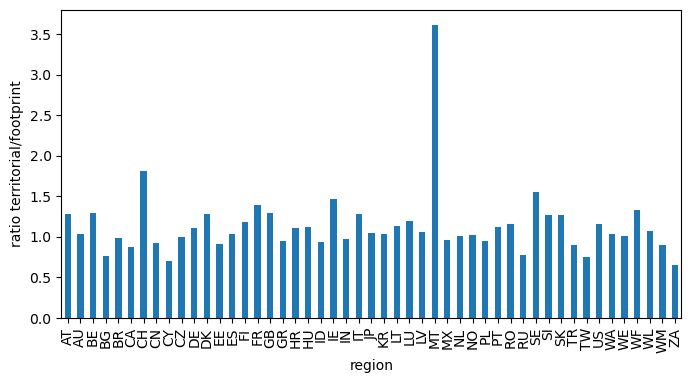

In [55]:
(e_fp_agg_co2_regions / e_territorial_agg_co2_regions).plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "ratio territorial/footprint",
)

### Question 3

Can you list the 10 products with the largest direct contribution to global territorial emissions in 2019?

In [56]:
# Display previous result
diagfX_co2

region                                                 AT                 \
sector                                         Paddy rice          Wheat   
stressor                                                                   
CO2 - combustion - air                               0.00 229,860,338.19   
CO2 - non combustion - Cement production - air       0.00           0.00   
CO2 - non combustion - Lime production - air         0.00           0.00   
CO2 - agriculture - peat decay - air                 0.00  21,572,911.22   
CO2 - waste - biogenic - air                         0.00           0.00   
CO2 - waste - fossil - air                           0.00           0.00   

region                                                            \
sector                                         Cereal grains nec   
stressor                                                           
CO2 - combustion - air                            228,239,802.62   
CO2 - non combustion - Cement production - air              0.00   
CO2 - non combustion - Lime production - air                0.00   
CO2 - agriculture - peat decay - air               34,455,387.04   
CO2 - waste - biogenic - air                                0.00   
CO2 - waste - fossil - air                                  0.00   

region                                                                  \
sector                                         Vegetables, fruit, nuts   
stressor                                                                 
CO2 - combustion - air                                  106,626,375.49   
CO2 - non combustion - Cement production - air                    0.00   
CO2 - non combustion - Lime production - air                      0.00   
CO2 - agriculture - peat decay - air                      9,057,874.57   
CO2 - waste - biogenic - air                                      0.00   
CO2 - waste - fossil - air                                        0.00   

region                                                        \
sector                                             Oil seeds   
stressor                                                       
CO2 - combustion - air                         49,787,015.08   
CO2 - non combustion - Cement production - air         45.75   
CO2 - non combustion - Lime production - air           18.66   
CO2 - agriculture - peat decay - air           11,268,750.04   
CO2 - waste - biogenic - air                            0.00   
CO2 - waste - fossil - air                              0.00   

region                                                                 \
sector                                         Sugar cane, sugar beet   
stressor                                                                
CO2 - combustion - air                                  12,844,898.81   
CO2 - non combustion - Cement production - air                   0.00   
CO2 - non combustion - Lime production - air                     0.00   
CO2 - agriculture - peat decay - air                     2,880,329.69   
CO2 - waste - biogenic - air                                     0.00   
CO2 - waste - fossil - air                                       0.00   

region                                                             \
sector                                         Plant-based fibers   
stressor                                                            
CO2 - combustion - air                                  10,930.59   
CO2 - non combustion - Cement production - air               0.00   
CO2 - non combustion - Lime production - air                 0.00   
CO2 - agriculture - peat decay - air                    33,560.87   
CO2 - waste - biogenic - air                                 0.00   
CO2 - waste - fossil - air                                   0.00   

region                                                                      \
sector                                             Crops nec        Cattle   
stressor              

In [66]:
# sum all CO2 extensions
diagfX_agg_co2 = diagfX_co2.sum(axis=0)

# Display intermediary result
diagfX_agg_co2

region  sector                                           
AT      Paddy rice                                                      0.00
        Wheat                                                 251,433,249.42
        Cereal grains nec                                     262,695,189.66
        Vegetables, fruit, nuts                               115,684,250.06
        Oil seeds                                              61,055,829.53
                                                                  ...       
WM      Membership organisation services n.e.c. (91)          379,790,550.44
        Recreational, cultural and sporting services (92)   1,406,964,130.01
        Other services (93)                                 4,380,106,107.51
        Private households with employed persons (95)          62,773,884.12
        Extra-territorial organizations and bodies                      0.00
Length: 9800, dtype: float64

In [58]:
# top regional sectors
diagfX_agg_co2.nlargest(10)

region  sector                                                             
CN      Electricity by coal                                                   2,759,066,881,460.00
        Cement, lime and plaster                                              1,446,014,292,555.00
        Basic iron and steel and of ferro-alloys and first products thereof   1,361,775,528,330.00
US      Electricity by coal                                                   1,186,314,937,770.00
IN      Electricity by coal                                                     971,366,136,724.17
CN      Chemicals nec                                                           591,250,718,434.00
US      Electricity by gas                                                      498,927,449,115.00
CN      Steam and hot water supply services                                     412,691,815,447.00
RU      Steam and hot water supply services                                     408,693,384,093.60
CN      Other non-metallic minera

In [57]:
# top sectors globally
diagfX_agg_co2.groupby("sector").sum().nlargest(10)

sector
Electricity by coal                                                   6,910,690,173,086.28
Cement, lime and plaster                                              2,545,888,747,595.59
Basic iron and steel and of ferro-alloys and first products thereof   1,899,985,772,676.07
Electricity by gas                                                    1,863,274,529,681.26
Steam and hot water supply services                                   1,413,841,880,297.72
Chemicals nec                                                         1,070,851,351,525.80
Air transport services (62)                                             903,749,892,812.58
Electricity by petroleum and other oil derivatives                      644,495,911,311.39
Sea and coastal water transportation services                           596,437,064,109.05
Other non-metallic mineral products                                     560,644,787,626.17
dtype: float64

### Question 4

Can you list the 10 products with the largest contribution from the carbon footprint perspective?

In [59]:
# sum CO2 extensions
f_agg_co2 = f.loc[CO2].sum(axis=0)

# Compute diag(f) @ L @ Y
fLdiagY_agg_co2 = (f_agg_co2 @ L) * Y.T
fLdiagY_agg_co2 = fLdiagY_agg_co2.T

# Display intermediary results
fLdiagY_agg_co2

region                                                                                            AT  \
category                                                 Final consumption expenditure by households   
region sector                                                                                          
AT     Paddy rice                                                                               0.00   
       Wheat                                                                           45,070,744.99   
       Cereal grains nec                                                               76,257,270.52   
       Vegetables, fruit, nuts                                                        142,922,515.21   
       Oil seeds                                                                                0.00   
...                                                                                              ...   
WM     Membership organisation services n.e.c. (91)                                         5,495.75   
       Recreational, cultural and sporting services (92)                                        0.00   
       Other services (93)                                                              2,187,715.92   
       Private households with employed persons (95)                                   20,213,248.61   
       Extra-territorial organizations and bodies                                               0.00   

region                                                                                                                                         \
category                                                 Final consumption expenditure by non-profit organisations serving households (NPISH)   
region sector                                                                                                                                   
AT     Paddy rice                                                                                      0.00                                     
       Wheat                                                                                           0.00                                     
       Cereal grains nec                                                                               0.00                                     
       Vegetables, fruit, nuts                                                                         0.00                                     
       Oil seeds                                                                                       0.00                                     
...                                                                                                     ...                                     
WM     Membership organisation services n.e.c. (91)                                            1,814,793.01                                     
       Recreational, cultural and sporting services (92)                                               0.00                                     
       Other services (93)                                                                             0.00                                     
       Private households with employed persons (95)                                                   0.00                                     
       Extra-territorial organizations and bodies                                                      0.00                                     

region                                                                                                \
category                                                 Final consumption expenditure by government   
region sector                                                                                          
AT     Paddy rice                                                                               0.00   
       Wheat                                                                                    

In [67]:
# Sum all columns (regions and FD categories)
fLdiagY_agg_co2_global = fLdiagY_agg_co2.sum(axis=1)

# Display intermediary results
fLdiagY_agg_co2_global

region  sector                                           
AT      Paddy rice                                                       0.00
        Wheat                                                  126,335,551.40
        Cereal grains nec                                       92,443,036.13
        Vegetables, fruit, nuts                                194,883,598.79
        Oil seeds                                               13,979,758.58
                                                                   ...       
WM      Membership organisation services n.e.c. (91)         7,416,335,580.83
        Recreational, cultural and sporting services (92)   16,670,593,033.86
        Other services (93)                                 14,113,961,340.60
        Private households with employed persons (95)          744,305,966.28
        Extra-territorial organizations and bodies                       0.00
Length: 9800, dtype: float64

In [61]:
# top regional sectors
fLdiagY_agg_co2_global.nlargest(10)

region  sector                                                                              
CN      Construction work (45)                                                                 4,321,838,646,942.16
        Health and social work services (85)                                                     824,367,405,827.79
        Machinery and equipment n.e.c. (29)                                                      601,520,363,398.57
US      Electricity by coal                                                                      593,032,299,874.81
        Public administration and defence services; compulsory social security services (75)     565,385,017,601.21
CN      Electrical machinery and apparatus n.e.c. (31)                                           474,601,322,285.71
IN      Construction work (45)                                                                   473,544,760,795.10
WM      Construction work (45)                                                                 

In [60]:
# top sectors globally
fLdiagY_agg_co2_global.groupby("sector").sum().nlargest(10)

sector
Construction work (45)                                                                 7,393,409,285,049.60
Health and social work services (85)                                                   1,620,344,148,395.68
Electricity by coal                                                                    1,514,270,506,262.59
Public administration and defence services; compulsory social security services (75)   1,512,092,078,066.69
Machinery and equipment n.e.c. (29)                                                    1,125,021,757,137.19
Motor vehicles, trailers and semi-trailers (34)                                          985,143,361,587.13
Real estate services (70)                                                                870,598,818,855.89
Electrical machinery and apparatus n.e.c. (31)                                           669,062,687,342.70
Electricity by gas                                                                       654,119,198,439.53
Education services (8

### Question 5

Identify the top 3 regions with the highest CO2 footprint and analyze their employment footprints in terms of hours or wages. What conclusions do you draw from the type of employment in those regions and their CO2 footprint?

In [62]:
fLdiagY_agg_co2_regions = fLdiagY_agg_co2.groupby('region', axis=1).sum()
fLdiagY_agg_co2_regions.sum(axis=0).nlargest(3)

region
CN   9,202,305,799,767.48
US   4,410,066,434,014.02
IN   2,145,486,287,759.28
dtype: float64

In [63]:
MASK = f.index.str.contains("wage") | f.index.str.contains("hour")
EMPL = f.loc[MASK].index
EMPL

Index(['Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled',
       'Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled',
       'Compensation of employees; wages, salaries, & employers' social contributions: High-skilled',
       'Employment hours: Low-skilled male',
       'Employment hours: Low-skilled female',
       'Employment hours: Medium-skilled male',
       'Employment hours: Medium-skilled female',
       'Employment hours: High-skilled male',
       'Employment hours: High-skilled female',
       'Employment hours: Vulnerable employment'],
      dtype='object', name='stressor')

In [64]:
f_empl = f.loc[EMPL]
countries = ['CN', 'US', 'IN']

# proceed as usual
results = f_empl @ LY[countries]
results.groupby('region', axis=1).sum()

region,CN,IN,US
stressor,,,
"Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled","734,171.97","146,222.54","416,597.76"
"Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled","3,512,386.73","658,678.78","5,569,321.39"
"Compensation of employees; wages, salaries, & employers' social contributions: High-skilled","1,911,631.92","353,141.95","4,676,481.28"
Employment hours: Low-skilled male,"364,018.50","168,653.36","48,991.49"
Employment hours: Low-skilled female,"111,324.59","43,486.63","24,526.70"
Employment hours: Medium-skilled male,"1,088,147.43","728,938.85","226,822.96"
Employment hours: Medium-skilled female,"579,845.18","266,433.89","157,667.90"
Employment hours: High-skilled male,"158,191.21","163,937.59","73,878.02"
Employment hours: High-skilled female,"94,625.00","47,880.57","62,079.26"
